## libraries

In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import keras
import tensorflow as tf
import keras.backend as K
from collections import Counter
from tensorflow.python.client import device_lib
from keras.optimizers import Adam, Adamax, SGD
import imutils
import tensorflow_addons as tfa
from keras.models import load_model

2023-01-12 12:02:17.503251: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 12:02:17.651436: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-12 12:02:17.679709: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 12:02:18.199175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)
tf.keras.backend.clear_session()
TF_ENABLE_ONEDNN_OPTS=0
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(tf.device('/gpu:0'))

tf.device('/gpu:0')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-12 12:02:21.656236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 12:02:23.271293: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:222] Using CUDA malloc Async allocator for GPU: 0
2023-01-12 12:02:23.271429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45356 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:19:00.0, compute capability: 8.6


In [3]:
base_path="/home/neel/Acoustic/Acoustics/dataset2"
audio_path=os.path.sep.join([base_path,"datachunks"])
annots_path=os.path.sep.join([base_path,"train.csv"])

base_output="/home/neel/Acoustic/Acoustics/output4.0"
test_file=os.path.sep.join([base_output,"test.txt"])

## Generate Spectrograms and labels

In [4]:
print("[INFO] loading dataset...")
rows = open(annots_path).read().strip().split("\n")
spectrogram=np.empty(((len(rows)),257,273,2), dtype="float32")
bounding_box_cords=[]
window_size=int(512)
wd = signal.windows.hamming(window_size)
slide_size = int(4)
overlap = window_size - slide_size
filenames=[]
cnt=0
for row in rows:
    # print(cnt)
    row = row.split(",")
    (filename1,filename2,X1, Y1, X2, Y2) = row
    channel1_Path = os.path.sep.join([audio_path, filename1])
    channel2_path = os.path.sep.join([audio_path, filename2])
    
    channel1,sample_rate=librosa.load(channel1_Path,sr=48000)
    channel2,sample_rate=librosa.load(channel2_path,sr=48000)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')

    # print(image1.shape)
    data=np.stack((spectrum1,spectrum2),axis=-1)
    spectrogram[cnt]=data
    del data,frequency,time
    cnt+=1
    bounding_box_cords.append((X1, Y1, X2, Y2))
    filenames.append([filename1,filename2])
    # filenames.append(filename1)
print("Done.")

[INFO] loading dataset...
Done.


## Normalize spectrogram

In [5]:
print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))
for i in range(8831):
    min=spectrogram[i].min()
    max=spectrogram[i].max()
    spectrogram[i]= (spectrogram[i]-min)/(max-min)


print('Min: %.3f, Max: %.3f' % (spectrogram.min(), spectrogram.max()))

Min: 0.000, Max: 0.036
Min: 0.000, Max: 1.000


In [6]:
del channel1,channel2,rows,spectrum1,spectrum2


In [7]:
targets = np.array(bounding_box_cords, dtype="float32")
print(targets.shape)
print(spectrogram.shape)

(14132, 4)
(14132, 257, 273, 2)


## Train - Validation split

In [8]:
split = train_test_split(spectrogram, targets, filenames, test_size=0.10,random_state=42)
del spectrogram, targets, filenames
(trainData, testData) = split[:2]
(trainTargets, testTargets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]
del split

print("[INFO] saving testing filenames...")
f = open(test_file, "w")
for i in testFilenames:
    f.write(i[0]+","+i[1])
    f.write("\n")
# f.write("\n".join(testFilenames))
f.close()

print("Training examples: ",trainData.shape)
print("Testing examples: ",testData.shape)

[INFO] saving testing filenames...
Training examples:  (12718, 257, 273, 2)
Testing examples:  (1414, 257, 273, 2)


## Model Building

#### VGG

In [ ]:
def vgg():
    model = tf.keras.Sequential()
    # Block 1
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv1", input_shape=(257,273,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same', name="block1_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block1_pool'))

    # Block 2
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv1"))
    model.add(tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding='same', name="block2_conv2"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block2_pool'))

    # Block 3
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv1"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv2"))
    model.add(tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same', name="block3_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block3_pool'))

    # Block 4
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block4_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block4_pool'))

    # Block 5
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv1"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv2"))
    model.add(tf.keras.layers.Conv2D(512,(3,3), activation='relu', padding='same', name="block5_conv3"))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2), name='block5_pool'))

    # FC 
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_1'))
    model.add(tf.keras.layers.Dense(4096, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_2'))
    model.add(tf.keras.layers.Dense(1024, activation='relu', name='fc_3'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_3'))
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dropout(0.5, name='dropout_4'))

    # Output
    model.add(tf.keras.layers.Dense(4, activation='relu', name='output'))

    model.summary()
    return model
model=vgg()
model.summary()


#### ANN

In [ ]:
def ANN():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(140322,)))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(4, activation='sigmoid'))

    return model
# model=ANN()
# model.summary()

#### cnn to dense

In [11]:
def cnn_dense():
    model= tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(64,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32,activation='relu'))
   
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

cnn_dense().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 136, 32)      608       
                                                                 
 batch_normalization (BatchN  (None, 128, 136, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 68, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 33, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 31, 33, 32)       128       
 hNormalization)                                                 
                                                        

#### CNN to Dense 2.0

In [ ]:
def cnn_dense_2():
    model= tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2, input_shape=(257,273,2), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.Conv2D(32,(3,3), padding='valid',strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid', strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPool2D((2,2), strides=(2,2)))
    
    model.add(tf.keras.layers.Conv2D(64,(3,3), padding='valid',strides=2,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(128,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
   
    model.add(tf.keras.layers.Dense(64,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
   
    model.add(tf.keras.layers.Dense(32,activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(4,activation='sigmoid'))
    
    return model

# cnn_dense_2().summary()

### Loss Function

In [12]:

def l2_loss_func(y_true, y_pred):
  return K.mean(K.square(y_pred - y_true))


def iou_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)
  x1_true, x2_true, x1_pred, x2_pred= x1_true*1920 , x2_true*1920, x1_pred*1920, x2_pred*1920
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)
  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
 
  iou = intersection / (area_true + area_pred - intersection)
  return 1-iou

def GIoU_loss_func(y_true, y_pred):
  # Convert the predicted and ground truth bounding boxes to a format
  # suitable for calculating the IOU
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)

  # Calculate the IOU between the predicted and ground truth bounding boxes
  x1_true, y1_true, x2_true, y2_true = tf.split(y_true, 4, axis=-1)
  x1_pred, y1_pred, x2_pred, y2_pred = tf.split(y_pred, 4, axis=-1)

  x1_true, x2_true, x1_pred, x2_pred= x1_true*1440 , x2_true*1440, x1_pred*1440, x2_pred*1440
  y1_true, y2_true, y1_pred, y2_pred= y1_true*1080 , y2_true*1080, y1_pred*1080, y2_pred*1080

  xmin_enclosing = K.minimum(x1_true, x1_pred)
  ymin_enclosing = K.minimum(y1_true, y1_pred)
  xmax_enclosing = K.maximum(x2_true, x2_pred)
  ymax_enclosing = K.maximum(y2_true, y2_pred)
  area_enclosing = (xmax_enclosing - xmin_enclosing) * (ymax_enclosing - ymin_enclosing)
  # Area of boxes
  area_true = (x2_true - x1_true + 1) * (y2_true - y1_true + 1)
  area_pred = (x2_pred - x1_pred + 1) * (y2_pred - y1_pred + 1)

  x1_true = K.maximum(x1_true, x1_pred)
  y1_true = K.maximum(y1_true, y1_pred)
  x2_true = K.minimum(x2_true, x2_pred)
  y2_true = K.minimum(y2_true, y2_pred)
  intersection = K.maximum(0.0, x2_true - x1_true + 1) * K.maximum(0.0, y2_true - y1_true + 1)
  
  # IoU
  iou = intersection / (area_true + area_pred - intersection)
  # calculate GIoU loss
  giou = K.maximum(1.0 - intersection / (area_true + area_pred - intersection) - (area_enclosing - (area_true + area_pred - intersection)) / area_enclosing, 0.0)
  
  return K.mean(giou)

def combined_loss(y_true, y_pred):
  # Calculate the Smooth L1 loss and IOU loss
  l2_loss = l2_loss_func(y_true, y_pred)
  iou_loss = iou_loss_func(y_true, y_pred)
  # giou_loss = GIoU_loss_func(y_true,y_pred)
  # Combine the losses with a weight
  loss = 0 * l2_loss + 1 * iou_loss
  return loss



### Accuracy

In [12]:
def mean_average_precision(y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    # Calculate Intersection Over Union (IOU) for each pair of true and pred boxes
    
    iou = -(iou_loss_func(y_true,y_pred)-1)
    # Set the threshold for considering a prediction as a true positive
    threshold = 0.6
    
    # Find the highest IOU for each true box
    best_iou = K.max(iou, axis=-1)
    
    # Find all predictions with IOU greater than the threshold
    true_positive = K.greater(iou, threshold)
    hit = sum(bool(x) for x in true_positive)
    # Find the average precision for all true boxes
    precision = []
    for t in np.arange(0.3, 0.8, 0.05):
        true_positive_at_t = K.cast(K.greater(best_iou, t), dtype='float32')
        precision.append(K.mean(true_positive_at_t))
    # return K.mean(K.stack(precision))
    return (hit/len(true_positive))


### Hyps

In [14]:
init_lr=1e-4
epoch=5000
batch_size=32
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    init_lr,
    decay_steps=200,
    decay_rate=0.1,
    staircase=True)
opt = SGD(learning_rate=lr_schedule ,momentum=0.9)


### Model Run

#### VGG 

In [ ]:
model=vgg()
model.compile(optimizer=opt, loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/vgg.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/vgg.png")

#### ANN

In [ ]:
trainData1=trainData.reshape(trainData.shape[0],-1)


In [ ]:
model=ANN()
model.compile(optimizer='adam', loss=tfa.losses.GIoULoss(), metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData1, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)


In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/ann.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["Accuracy"], label="train_loss")
plt.title("Bounding Box Regression MSE on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_output+"/ann.png")

#### CNN DENSE

In [15]:
model=cnn_dense()
model.compile(optimizer='adam', loss=combined_loss, metrics=[mean_average_precision] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		validation_data=(testData, testTargets),
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)
model.save(base_output+"/cnn_dense_5000.h5", save_format="h5")

Epoch 1/5000


2023-01-11 16:21:50.699369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-01-11 16:21:51.933204: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


398/398 [==============================] - 15s 27ms/step - loss: 0.9913 - mean_average_precision: 2.0190e-04 - val_loss: 0.9639 - val_mean_average_precision: 0.0000e+00
Epoch 2/5000
398/398 [==============================] - 9s 22ms/step - loss: 0.9787 - mean_average_precision: 4.4867e-05 - val_loss: 0.9580 - val_mean_average_precision: 0.0000e+00
Epoch 3/5000
398/398 [==============================] - 9s 23ms/step - loss: 0.9684 - mean_average_precision: 5.6084e-05 - val_loss: 0.9554 - val_mean_average_precision: 0.0000e+00
Epoch 4/5000
398/398 [==============================] - 9s 23ms/step - loss: 0.9610 - mean_average_precision: 1.3460e-04 - val_loss: 0.9505 - val_mean_average_precision: 0.0000e+00
Epoch 5/5000
398/398 [==============================] - 9s 24ms/step - loss: 0.9554 - mean_average_precision: 8.9734e-05 - val_loss: 0.9475 - val_mean_average_precision: 0.0000e+00
Epoch 6/5000
398/398 [==============================] - 9s 23ms/step - loss: 0.9521 - mean_average_precisio

[INFO] saving object detector model...


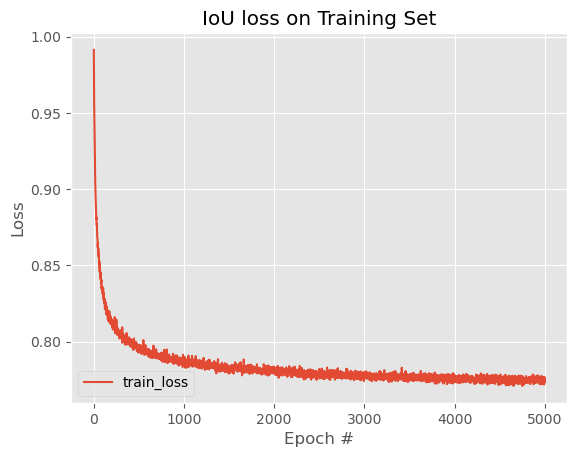

In [22]:
print("[INFO] saving object detector model...")
# model.save(base_output+"/cnn_dense_5000.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("IoU loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
# plt.savefig(base_output+"/cnn_dense_5000.png")

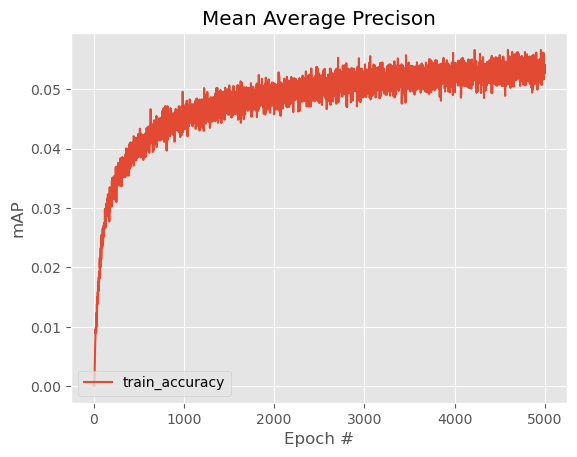

In [17]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["mean_average_precision"], label="train_accuracy")
plt.title("Mean Average Precison")
plt.xlabel("Epoch #")
plt.ylabel("mAP")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense_5000_acc.png")

#### CNN DENSE 2.0

In [ ]:
model=cnn_dense_2()
model.compile(optimizer='adam', loss=combined_loss, metrics=['Accuracy'] )
with tf.device("/gpu:0"):
	H = model.fit(
		trainData, trainTargets,
		batch_size=batch_size,
		epochs=epoch,
		verbose=1)
	print(H)

In [ ]:
print("[INFO] saving object detector model...")
model.save(base_output+"/cnn_dense_2_iou.h5", save_format="h5")
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.title("L2 + GIoU loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(base_output+"/cnn_dense_2_iou.png")

## Testing

In [9]:
model=load_model(base_output+"/cnn_dense_5000.h5", compile=False)
pred=[]
gd=[]
for i,img in enumerate(testFilenames):
    if i==100:
        break
    audioPath1=os.path.sep.join([audio_path, img[0]])
    audioPath2=os.path.sep.join([audio_path, img[1]])
    channel1,sample_rate=librosa.load(audioPath1,sr=48000)
    channel2,sample_rate=librosa.load(audioPath2,sr=48000)

    frequency,time,spectrum1=signal.spectrogram(channel1,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    frequency,time,spectrum2=signal.spectrogram(channel2,nfft=window_size,fs=sample_rate,window=wd,noverlap=overlap,mode='magnitude')
    spectrum1=np.expand_dims(spectrum1,axis=0)
    spectrum2=np.expand_dims(spectrum2,axis=0)
    spectrogram=np.stack((spectrum1,spectrum2),axis=-1)

    # normalize
    min=spectrogram.min()
    max=spectrogram.max()
    spectrogram= (spectrogram-min)/(max-min)
    preds = model.predict(spectrogram)[0]
    (startX, startY, endX, endY) = preds
    startX,endX=startX*1920, endX*1920
    startY,endY=startY*1080, endY*1080
    width=endX-startX
    height=endY-startY
    f=open("/home/neel/Acoustic/Acoustics/dataset2/labels/"+img[0][9:-4]+".txt")
    ground_truth=f.read().replace('\n','').split(" ")
    ground_startX=float(ground_truth[1])
    ground_startY=float(ground_truth[2])
    ground_width=(float(ground_truth[3])-ground_startX)
    ground_height=(float(ground_truth[4])-ground_startY)
    print("Image name: ",img[0])
    print("Ground truth: ",ground_startX,ground_startY,ground_width,ground_height)
    print("Predicted: ",startX, startY, width, height)
    pred.append([startX,startY,endX,endY])
    gd.append([ground_startX,ground_startY,float(ground_truth[3]),float(ground_truth[4])])
    

2023-01-12 12:03:49.390654: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 2s 2s/step
Image name:  channel1_new_video286_14.wav
Ground truth:  185.0 390.0 260.0 147.0
Predicted:  68.21919679641724 379.95973348617554 380.0877642631531 133.65959286689758
1/1 [==============================] - 0s 26ms/step
Image name:  channel1_new_video466_17.wav
Ground truth:  1430.0 528.0 490.0 194.0
Predicted:  1397.1185302734375 549.3877100944519 492.2266387939453 223.5603404045105
1/1 [==============================] - 0s 28ms/step


2023-01-12 12:03:50.602018: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Image name:  channel1_new_video252_2.wav
Ground truth:  1171.0 491.0 194.0 95.0
Predicted:  1036.5289306640625 468.90573263168335 383.4690856933594 119.39456462860107
1/1 [==============================] - 0s 26ms/step
Image name:  channel1_new_video332_27.wav
Ground truth:  262.0 432.0 590.0 199.0
Predicted:  468.08295249938965 386.084246635437 376.84807777404785 129.87285017967224
1/1 [==============================] - 0s 26ms/step
Image name:  channel1_new_video38_25.wav
Ground truth:  1220.0 613.0 251.0 125.0
Predicted:  994.5221328735352 577.9037976264954 466.8701934814453 199.12434339523315
1/1 [==============================] - 0s 18ms/step
Image name:  channel1_new_video129_21.wav
Ground truth:  172.0 647.0 179.0 96.0
Predicted:  174.17770385742188 562.7021098136902 436.41368865966797 182.5920009613037
1/1 [==============================] - 0s 19ms/step
Image name:  channel1_new_video299_26.wav
Ground truth:  1630.0 346.0 258.0 131.0
Predicted:  1542.0278549194336 356.866235733

In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt
import cv2

startX,startY, width, height= 510.322265625, 503.85673999786377 ,315.5558395385742 ,179.6698522567749
X,Y,W,H=571.0 ,524.0, 189.0 ,98.0

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/new_video249_8.jpg')
plt.imshow(image)
plt.axis('off')
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((X,Y),W,H, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)

In [ ]:
startX,startY, width, height= 547.1884059906006, 368.9298355579376, 184.8526096343994, 127.15006470680237
X,Y,W,H=481.99968, 332.4996 ,168.00048 ,96.999984
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

image = plt.imread('/home/neel/Acoustic/yolov5_training/img_data/frames/3m_train16_15.jpg')
plt.imshow(image)
rect = patches.Rectangle((startX,startY), width, height, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((397,284),169,97, edgecolor='g', facecolor='none')
ax.add_patch(rect)
ax.add_patch(rect2)

In [10]:
print(gd)

[[185.0, 390.0, 445.0, 537.0], [1430.0, 528.0, 1920.0, 722.0], [1171.0, 491.0, 1365.0, 586.0], [262.0, 432.0, 852.0, 631.0], [1220.0, 613.0, 1471.0, 738.0], [172.0, 647.0, 351.0, 743.0], [1630.0, 346.0, 1888.0, 477.0], [180.0, 617.0, 660.0, 809.0], [907.0, 945.0, 1278.0, 1080.0], [571.0, 524.0, 760.0, 622.0], [1002.0, 480.0, 1174.0, 562.0], [812.0, 516.0, 1024.0, 628.0], [0.0, 12.0, 158.0, 185.0], [531.0, 156.0, 672.0, 247.0], [988.0, 480.0, 1140.0, 564.0], [444.0, 0.0, 728.0, 174.0], [332.0, 600.0, 887.0, 831.0], [422.0, 632.0, 904.0, 817.0], [1022.0, 485.0, 1170.0, 567.0], [707.0, 396.0, 927.0, 515.0], [1190.0, 278.0, 1555.0, 468.0], [1257.0, 31.0, 1640.0, 247.0], [292.0, 539.0, 681.0, 732.0], [154.0, 343.0, 536.0, 539.0], [837.0, 62.0, 1018.0, 193.0], [794.0, 164.0, 1043.0, 335.0], [1706.0, 329.0, 1920.0, 442.0], [1675.0, 374.0, 1920.0, 508.0], [1205.0, 285.0, 1427.0, 423.0], [189.0, 33.0, 446.0, 198.0], [6.0, 588.0, 722.0, 802.0], [1084.0, 416.0, 1557.0, 651.0], [1004.0, 337.0, 121

In [11]:
print(pred)

[[68.21919679641724, 379.95973348617554, 448.3069610595703, 513.6193263530731], [1397.1185302734375, 549.3877100944519, 1889.3451690673828, 772.9480504989624], [1036.5289306640625, 468.90573263168335, 1419.9980163574219, 588.3002972602844], [468.08295249938965, 386.084246635437, 844.9310302734375, 515.9570968151093], [994.5221328735352, 577.9037976264954, 1461.3923263549805, 777.0281410217285], [174.17770385742188, 562.7021098136902, 610.5913925170898, 745.2941107749939], [1542.0278549194336, 356.8662357330322, 1902.7642822265625, 499.28364872932434], [253.40938568115234, 497.0616853237152, 664.7489547729492, 651.2385034561157], [1143.0342864990234, 96.39359503984451, 1681.0652160644531, 375.91102480888367], [567.2232627868652, 500.1382648944855, 810.6345176696777, 635.1990652084351], [934.4699478149414, 468.9425218105316, 1198.952407836914, 581.2007904052734], [745.594596862793, 492.64147996902466, 1022.8430557250977, 626.3628387451172], [11.526619791984558, 13.0398890376091, 222.8778